In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
%matplotlib inline

# 0. Functions

In [2]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [3]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    #print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    #print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    #print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    #print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    return meds, maxs

In [4]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 10000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [5]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

## (a) Get test sample for LL calcs

In [6]:
# Choosing PHWR sample intentionally
sim_idx = 65331
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65331,phwr,1883.227187,0.711,3383.22,candu37


## (b) LL calcs for uncertainty = 2.8%, 5.6%, 8.4%, 11.2%

In [7]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [8]:
uncs = [0.028, 0.056, 0.084, 0.112]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

## (c) Half trainset + full trainset

In [13]:
trainXY = fullXY.sample(frac=0.5)

# 2. LogLikelihood for 3 reactors with Uncertainty = 11%

In [10]:
ll = 'LogLikelihood_0.112'
zname = [ll, ll, ll, ll]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

## (a) Half trainset

In [14]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll)
plotXY1 = trainXY_pwr.loc[trainXY_pwr[ll] > meds[0]]
plotXY2 = trainXY_agr.loc[trainXY_agr[ll] > meds[1]]
plotXY3 = trainXY_phwr.loc[trainXY_phwr[ll] > meds[2]]
plotXY4 = trainXY.loc[trainXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


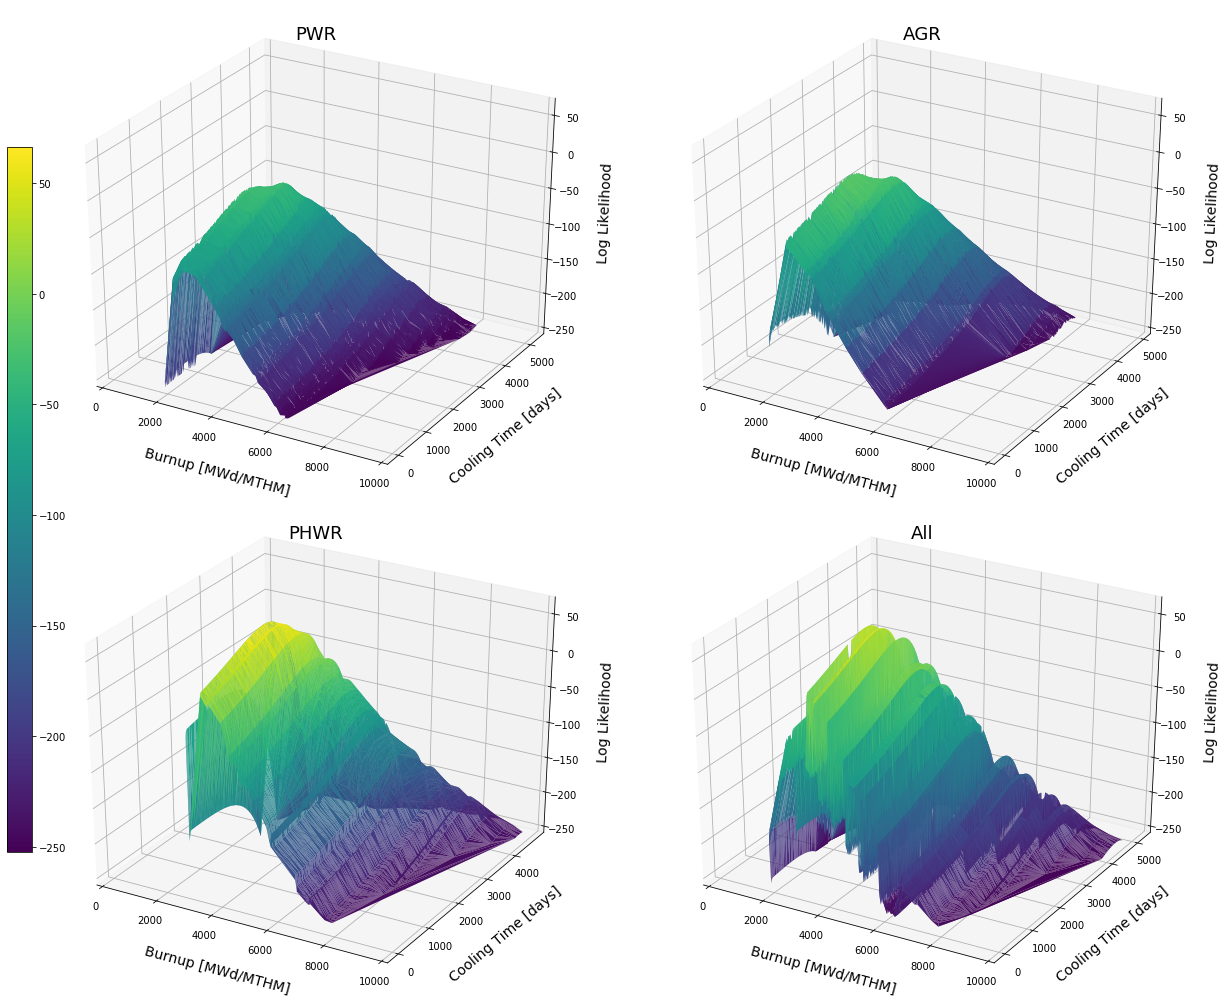

In [15]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

## (b) Full trainset

In [16]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


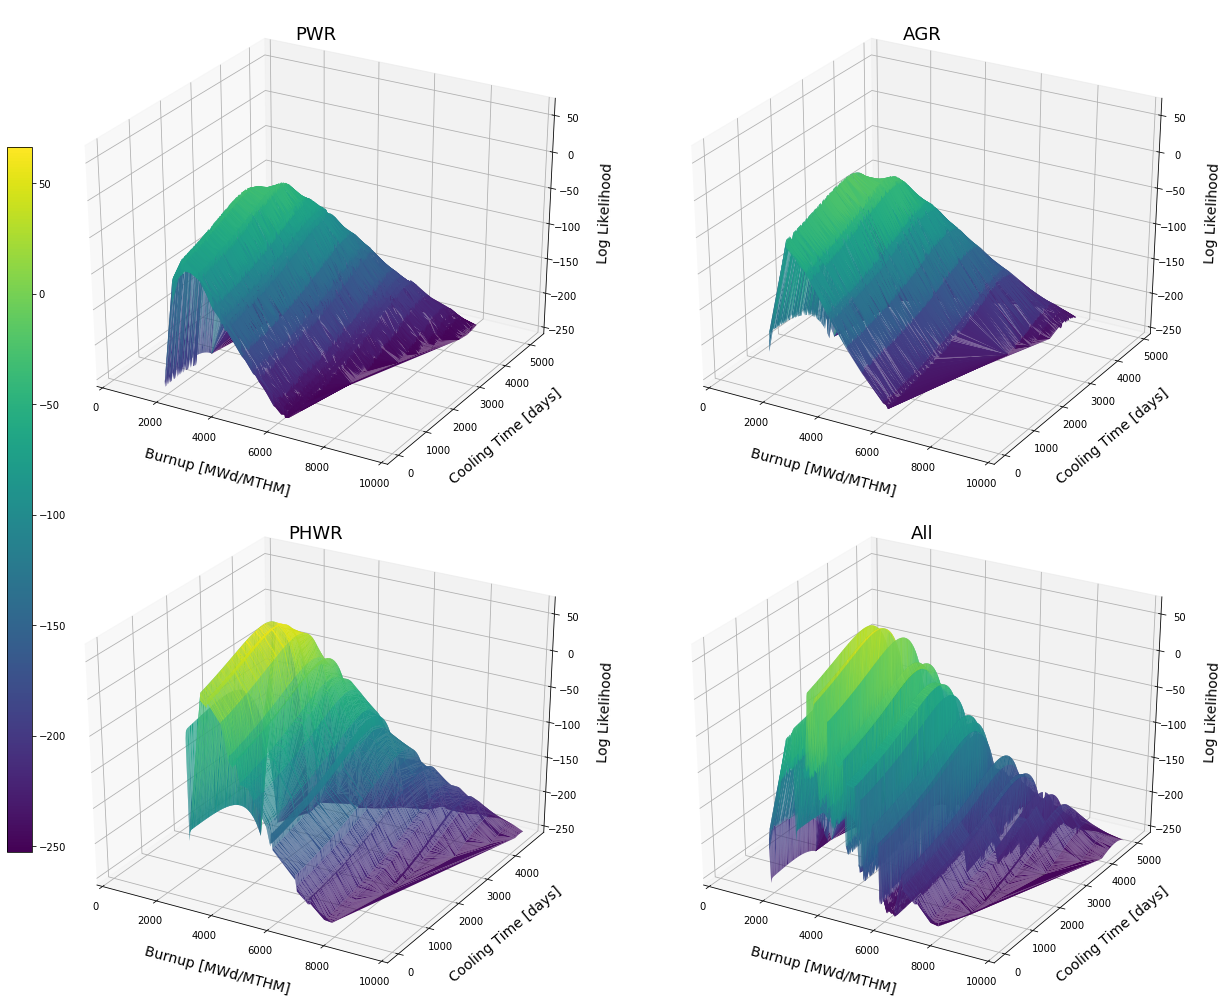

In [17]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [18]:
ll1 = 'LogLikelihood_0.028'
ll2 = 'LogLikelihood_0.056'
ll3 = 'LogLikelihood_0.084'
ll4 = 'LogLikelihood_0.112'
zname = [ll1, ll2, ll3, ll4]
uncss = ['2.8% Unc', '5.6% Unc', '8.4% Unc', '11.2% Unc']

## (a) Half trainset

In [19]:
meds, maxs = getstats_unc(trainXY, ll1, ll2, ll3, ll4)

2.8% Median: -4655.506270119128 
 Stats: DescribeResult(nobs=36573, minmax=(-47403486479.15716, 87.24558183615221), mean=-242921583.8805102, variance=4.987931878880804e+18, skewness=-10.264918763861864, kurtosis=112.36750255162183) 

5.6% Median: -1124.4480283865287 
 Stats: DescribeResult(nobs=36573, minmax=(-11850871524.43281, 76.85047198887432), mean=-60730347.59275165, variance=3.117457372166768e+17, skewness=-10.264918791874885, kurtosis=112.36750321385526) 

8.4% Median: -474.3190848947891 
 Stats: DescribeResult(nobs=36573, minmax=(-5267053944.381165, 70.76903867031615), mean=-26991233.91825304, variance=6.157940316596974e+16, skewness=-10.264918838563226, kurtosis=112.36750431757734) 

11.2% Median: -248.95696074188928 
 Stats: DescribeResult(nobs=36573, minmax=(-2962717793.5496287, 66.45399773961194), mean=-15182546.318717793, variance=1.9484107272699124e+16, skewness=-10.26491890392686, kurtosis=112.3675058627875) 



In [20]:
cutoff = -2500

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


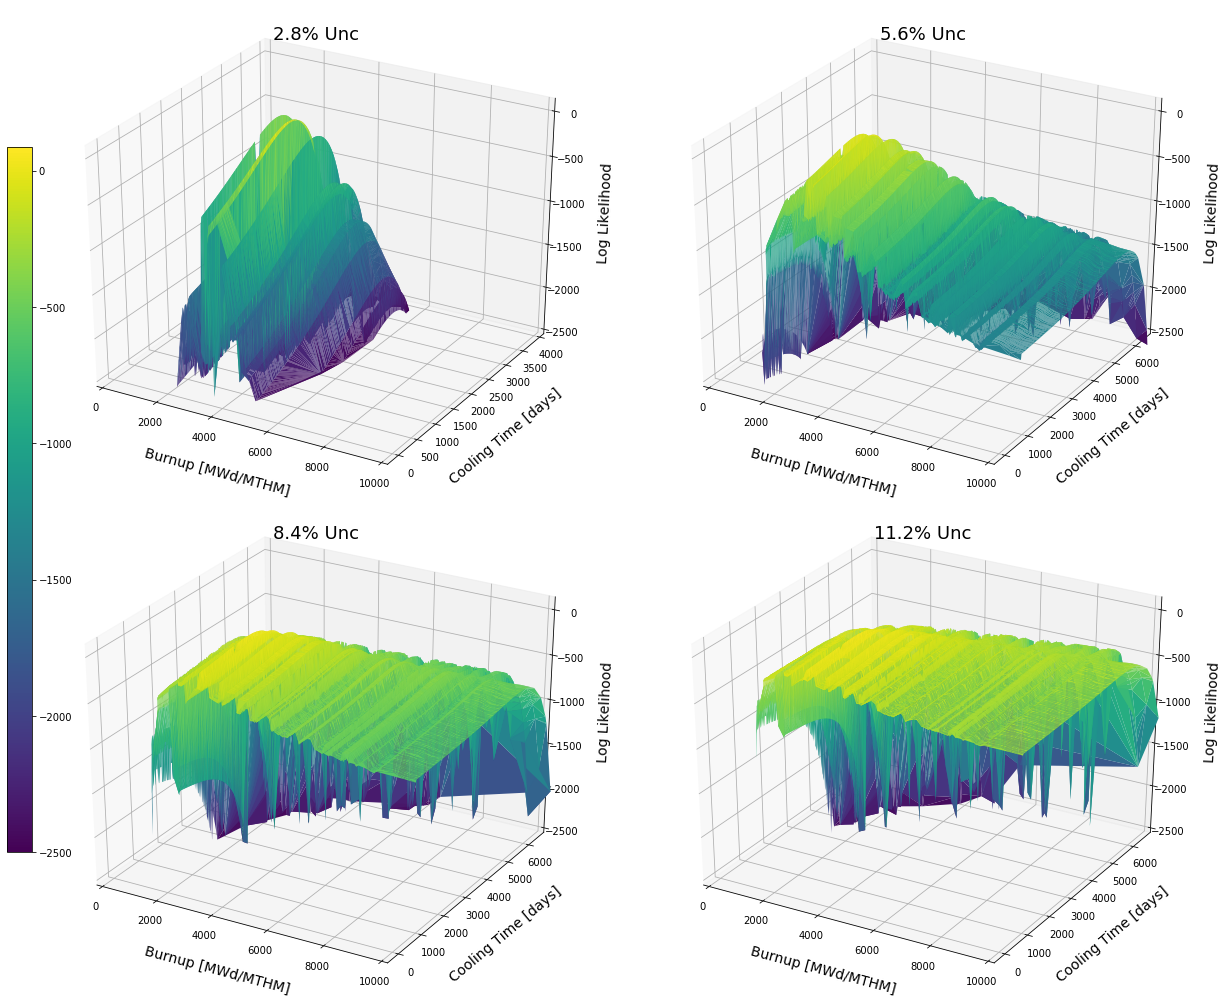

In [21]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))

## (b) Full trainset

In [22]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -4654.185386669311 
 Stats: DescribeResult(nobs=73146, minmax=(-52306366591.27543, 87.24558183615221), mean=-248348075.00318956, variance=5.162133924256292e+18, skewness=-10.169449232832395, kurtosis=110.16796369125029) 

5.6% Median: -1124.0823739282782 
 Stats: DescribeResult(nobs=73146, minmax=(-13076591552.354626, 76.85047198887432), mean=-62086970.41849152, variance=3.226333649269764e+17, skewness=-10.169449259289005, kurtosis=110.16796431767646) 

8.4% Median: -474.304301367418 
 Stats: DescribeResult(nobs=73146, minmax=(-5811818401.155492, 70.76903867031615), mean=-27594177.42974485, variance=6.37300456352738e+16, skewness=-10.169449303383347, kurtosis=110.16796536171978) 

11.2% Median: -248.86582710883954 
 Stats: DescribeResult(nobs=73146, minmax=(-3269147800.4223323, 66.46270083428878), mean=-15521702.070222782, variance=2.016458397317569e+16, skewness=-10.169449365115364, kurtosis=110.16796682337954) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


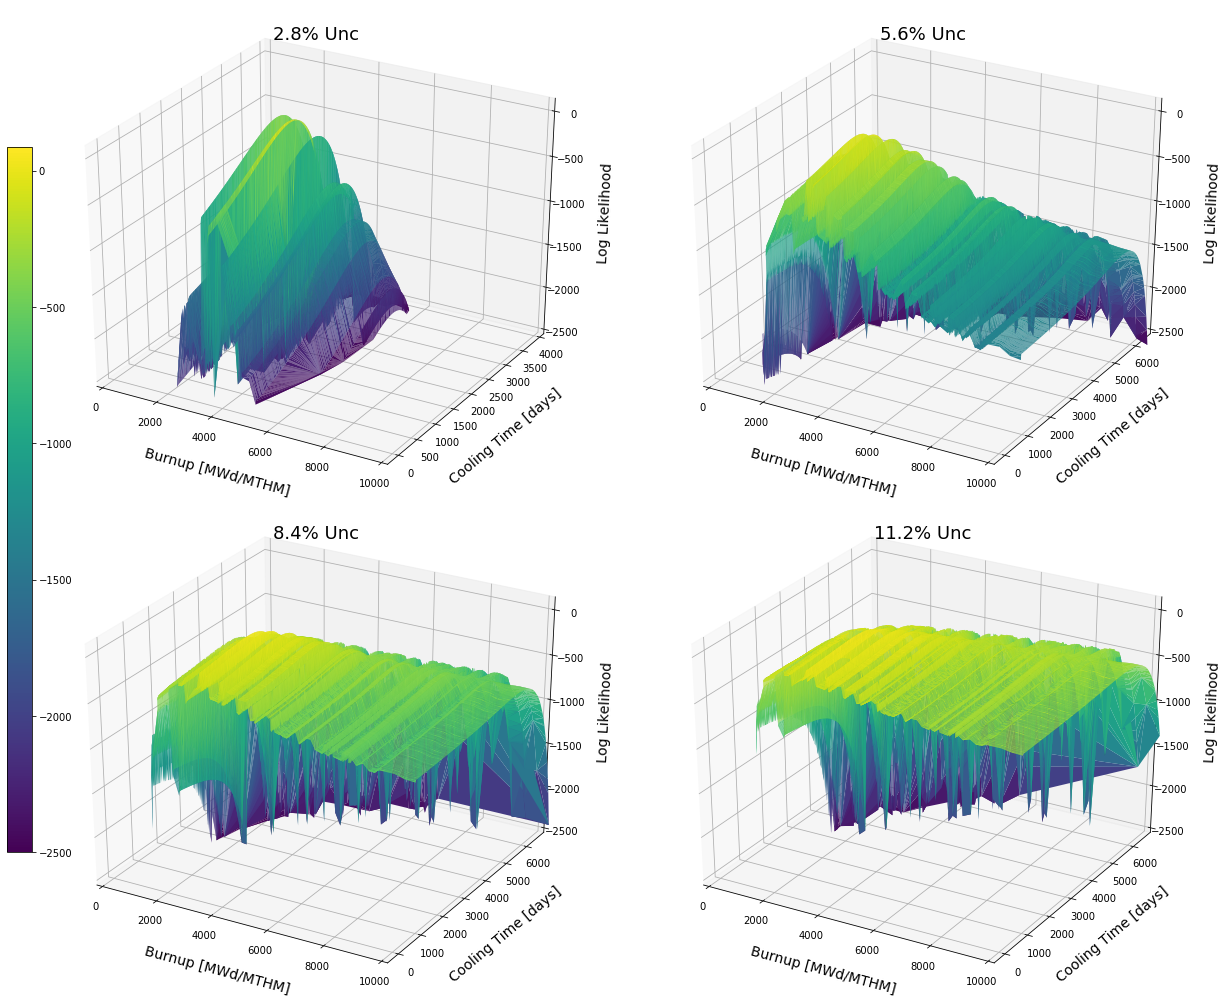

In [23]:
plotXY1 = fullXY.loc[fullXY[ll1] > cutoff]
plotXY2 = fullXY.loc[fullXY[ll2] > cutoff]
plotXY3 = fullXY.loc[fullXY[ll3] > cutoff]
plotXY4 = fullXY.loc[fullXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))